In [1]:
import os
os.environ['PYTHONHASHSEED'] = '1234'
import random
random.seed(43)
import numpy as np
np.random.seed(43)
import pandas as pd
import optuna   
import tensorflow as tf
tf.random.set_seed(43)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,  balanced_accuracy_score
from sklearn.metrics import f1_score
import gc
from tensorflow.keras import backend as K

/home/toyotx22/bitcoin_sentiment_forecaster/tf_venv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-17 23:23:49.925255: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-17 23:23:49.990693: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-17 23:23:49.990806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-17 23:23:49.994262: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to regist

In [2]:
SEED = 43
 # Se puede cambiar a "precision" o "recall" o "f1-score"
SCORE = "f1-score"

Score Trend Changes Score

In [3]:
def trend_changes_score(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(y_df["is_changed_trend_test"][:-1], y_df["is_changed_trend_predict"][:-1], digits=4)

def trend_changes_true(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    report = classification_report(
        y_df["is_changed_trend_test"][:-1],
        y_df["is_changed_trend_predict"][:-1],
        output_dict=True,
        zero_division=0
    )
    return report["True"][SCORE]

In [4]:
training_set = pd.read_csv("../../../data/training_set.csv", parse_dates=['date'])
validation_set = pd.read_csv("../../../data/validation_set.csv", parse_dates=['date'])
test_set = pd.read_csv("../../../data/test_set.csv", parse_dates=['date'])
# Cargar datos
X_train = training_set.drop(columns=['target_trend','date']).values
y_train = training_set['target_trend'].values
X_val = validation_set.drop(columns=['target_trend','date']).values
y_validation = validation_set['target_trend'].values
X_test = test_set.drop(columns=['target_trend','date']).values
y_test = test_set['target_trend'].values    

IMPORTANTE: Hay que sumar a la columna de prediccion porque -1 no funciona en funcion de LOSS

In [5]:
y_train += 1
y_validation += 1
y_test += 1

Compilacion y entrenamiento de la red

In [6]:
# Definición de hiperparámetros
learning_rate = 0.001
n_l1 = 100 #100
n_l2 = 60  #60
n_l3 = 30  #30
n_l4 = 10  #10

# Definición del modelo
model = Sequential(
    [               
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(n_l1,activation='relu',name='L1'),
        Dense(n_l2,activation='relu',name='L2'),
        Dense(n_l3,activation='relu',name='L3'),
        Dense(n_l4,activation='relu',name='L4'),
        Dense(3,activation='linear',name='L5'),
    ], name = "multiclass"
)

2025-08-17 23:23:53.027918: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-17 23:23:53.028730: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
model.summary()

Model: "multiclass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 100)               5100      
                                                                 
 L2 (Dense)                  (None, 60)                6060      
                                                                 
 L3 (Dense)                  (None, 30)                1830      
                                                                 
 L4 (Dense)                  (None, 10)                310       
                                                                 
 L5 (Dense)                  (None, 3)                 33        
                                                                 
Total params: 13333 (52.08 KB)
Trainable params: 13333 (52.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Compilación del modelo
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=['accuracy']
)
# Detiene el entrenamiento si val_loss no mejora después de 10 épocas seguidas
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
# checkpoint = ModelCheckpoint(
#     filepath='best_model.keras',
#     monitor='val_loss',
#     save_best_only=True
# )
history = model.fit(
    X_train,y_train,
    epochs=60,
    validation_data=(X_val, y_validation),
    callbacks=[early_stop]
)


Epoch 1/60
19/19 [==============================] - 1s 17ms/step - loss: 706.8396 - accuracy: 0.3911 - val_loss: 260.7101 - val_accuracy: 0.5846
Epoch 2/60
19/19 [==============================] - 0s 6ms/step - loss: 154.2198 - accuracy: 0.4785 - val_loss: 137.3513 - val_accuracy: 0.6308
Epoch 3/60
19/19 [==============================] - 0s 6ms/step - loss: 256.3345 - accuracy: 0.5033 - val_loss: 468.1496 - val_accuracy: 0.4769
Epoch 4/60
19/19 [==============================] - 0s 6ms/step - loss: 110.5332 - accuracy: 0.5512 - val_loss: 157.0640 - val_accuracy: 0.5308
Epoch 5/60
19/19 [==============================] - 0s 6ms/step - loss: 102.9813 - accuracy: 0.5908 - val_loss: 331.5060 - val_accuracy: 0.4077
Epoch 6/60
19/19 [==============================] - 0s 4ms/step - loss: 84.1960 - accuracy: 0.5743 - val_loss: 178.2449 - val_accuracy: 0.5308
Epoch 7/60
19/19 [==============================] - 0s 4ms/step - loss: 54.7477 - accuracy: 0.6452 - val_loss: 162.1622 - val_accuracy: 

In [9]:
loss, accuracy = model.evaluate(X_val, y_validation)

5/5 [==============================] - 0s 2ms/step - loss: 34.9355 - accuracy: 0.7769


Grafica de Loss y Accuracy en train_set & validation_set

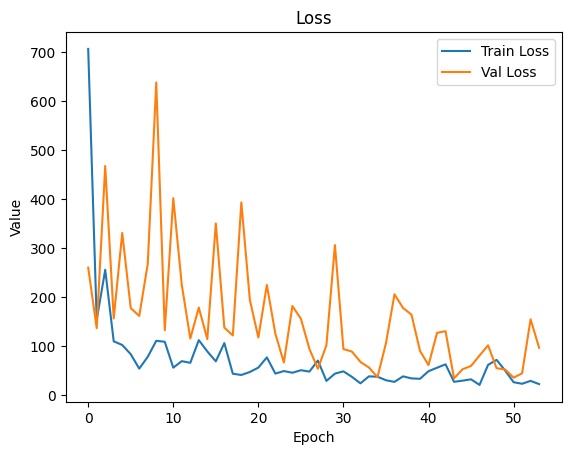

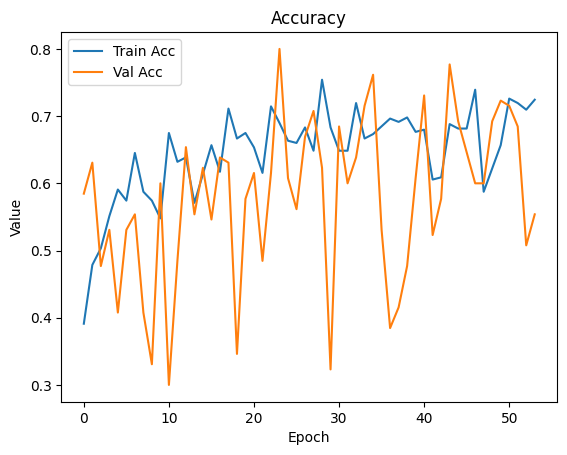

In [10]:
# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.show()


F1 SCORE

In [11]:
# Obtener predicciones
y_pred_val = np.argmax(model.predict(X_val), axis=1)
# Reporte completo: precisión, recall y F1 por clase
report = classification_report(y_validation, y_pred_val, digits=4)
print("Multiclass Neural Network Report:\n", report)
print("Balanced accuracy:", balanced_accuracy_score(y_validation, y_pred_val))


5/5 [==============================] - 0s 2ms/step
Multiclass Neural Network Report:
               precision    recall  f1-score   support

           0     0.8000    0.8333    0.8163        24
           1     0.0833    0.0556    0.0667        18
           2     0.8602    0.9091    0.8840        88

    accuracy                         0.7769       130
   macro avg     0.5812    0.5993    0.5890       130
weighted avg     0.7415    0.7769    0.7583       130

Balanced accuracy: 0.5993265993265994


In [12]:
print("Multiclass Neural Network trend_changes_score:\n",
    trend_changes_score(y_validation, y_pred_val)
)

Multiclass Neural Network trend_changes_score:
               precision    recall  f1-score   support

       False     0.9074    0.8750    0.8909       112
        True     0.3333    0.4118    0.3684        17

    accuracy                         0.8140       129
   macro avg     0.6204    0.6434    0.6297       129
weighted avg     0.8318    0.8140    0.8221       129



OPTIMIZACION CON OPTUNA

In [13]:
def objective(trial):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    # Hiperparámetros a optimizar
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    n_l1 = trial.suggest_int("n_l1", 32, 256, step=32)
    n_l2 = trial.suggest_int("n_l2", 32, 256, step=32)
    n_l3 = trial.suggest_int("n_l3", 16, 128, step=16)
    n_l4 = trial.suggest_int("n_l4", 8, 64, step=8)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "selu"])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "rmsprop", "sgd"])
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])

    # Optimizer
    optimizer = {
        "adam": tf.keras.optimizers.Adam,
        "rmsprop": tf.keras.optimizers.RMSprop,
        "sgd": tf.keras.optimizers.SGD
    }[optimizer_name](learning_rate=learning_rate)

    # Modelo
    model = Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(n_l1, activation=activation),
        Dropout(dropout_rate),
        Dense(n_l2, activation=activation),
        Dropout(dropout_rate),
        Dense(n_l3, activation=activation),
        Dropout(dropout_rate),
        Dense(n_l4, activation=activation),
        Dropout(dropout_rate),
        Dense(3, activation='linear')  # 3 clases
    ])

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )

    # Entrenamiento
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_validation),
        epochs=60,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    # Predicción y evaluación con tu métrica personalizada
    y_pred_logits = model.predict(X_val)
    y_pred = np.argmax(y_pred_logits, axis=1)

    score = trend_changes_true(y_validation, y_pred)
    # Liberar memoria GPU y limpiar sesión
    K.clear_session()
    gc.collect()
    return score  # Este es el valor que Optuna maximiza

In [14]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=200)

[I 2025-08-17 23:23:59,421] A new study created in memory with name: no-name-29f4af98-17c1-42f7-bdc3-6f45c5705879


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:01,719] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 2.2139290514335146e-05, 'n_l1': 160, 'n_l2': 64, 'n_l3': 32, 'n_l4': 24, 'dropout_rate': 0.42956874547429885, 'activation': 'relu', 'optimizer': 'sgd', 'batch_size': 256}. Best is trial 0 with value: 0.0.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:00,893] Trial 1 finished with value: 0.08 and parameters: {'learning_rate': 4.603487705829326e-05, 'n_l1': 128, 'n_l2': 96, 'n_l3': 16, 'n_l4': 56, 'dropout_rate': 0.4244695738724307, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 1 with value: 0.08.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:05,401] Trial 2 finished with value: 0.14814814814814814 and parameters: {'learning_rate': 1.036068923012556e-05, 'n_l1': 160, 'n_l2': 128, 'n_l3': 96, 'n_l4': 64, 'dropout_rate': 0.45433137891554387, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 2 with value: 0.14814814814814814.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:09,416] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 6.709286383037111e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 64, 'n_l4': 64, 'dropout_rate': 0.36786354075356037, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 2 with value: 0.14814814814814814.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:11,366] Trial 4 finished with value: 0.0 and parameters: {'learning_rate': 4.151887265119394e-05, 'n_l1': 64, 'n_l2': 224, 'n_l3': 48, 'n_l4': 48, 'dropout_rate': 0.14980838790351242, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 2 with value: 0.14814814814814814.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:14,106] Trial 5 finished with value: 0.11320754716981132 and parameters: {'learning_rate': 2.033425828832714e-05, 'n_l1': 256, 'n_l2': 160, 'n_l3': 128, 'n_l4': 16, 'dropout_rate': 0.29722459340921537, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 2 with value: 0.14814814814814814.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:16,322] Trial 6 finished with value: 0.0 and parameters: {'learning_rate': 0.0040789128952500725, 'n_l1': 256, 'n_l2': 256, 'n_l3': 96, 'n_l4': 16, 'dropout_rate': 0.21733916054340263, 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 2 with value: 0.14814814814814814.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:18,505] Trial 7 finished with value: 0.0 and parameters: {'learning_rate': 0.0014011907433416567, 'n_l1': 256, 'n_l2': 224, 'n_l3': 32, 'n_l4': 64, 'dropout_rate': 0.2761320735057018, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 2 with value: 0.14814814814814814.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:20,287] Trial 8 finished with value: 0.0 and parameters: {'learning_rate': 0.0008572578878125053, 'n_l1': 64, 'n_l2': 192, 'n_l3': 16, 'n_l4': 8, 'dropout_rate': 0.16724449577646616, 'activation': 'relu', 'optimizer': 'sgd', 'batch_size': 64}. Best is trial 2 with value: 0.14814814814814814.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:23,002] Trial 9 finished with value: 0.0 and parameters: {'learning_rate': 0.0015339533443798257, 'n_l1': 96, 'n_l2': 160, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.18927766972578491, 'activation': 'tanh', 'optimizer': 'sgd', 'batch_size': 64}. Best is trial 2 with value: 0.14814814814814814.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:26,831] Trial 10 finished with value: 0.5 and parameters: {'learning_rate': 1.0392362647105484e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.004810004645591226, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 10 with value: 0.5.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:29,933] Trial 11 finished with value: 0.5098039215686274 and parameters: {'learning_rate': 1.1109913078906763e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.009232280612909063, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:29,753] Trial 12 finished with value: 0.1935483870967742 and parameters: {'learning_rate': 0.00018507350627476488, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.008676942023290526, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:33,208] Trial 13 finished with value: 0.2608695652173913 and parameters: {'learning_rate': 0.00018663303002514794, 'n_l1': 192, 'n_l2': 96, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.007627740627497698, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:36,119] Trial 14 finished with value: 0.0 and parameters: {'learning_rate': 1.2876044354237173e-05, 'n_l1': 192, 'n_l2': 32, 'n_l3': 80, 'n_l4': 40, 'dropout_rate': 0.08436622823854945, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:38,685] Trial 15 finished with value: 0.0 and parameters: {'learning_rate': 0.0001066880118380891, 'n_l1': 224, 'n_l2': 96, 'n_l3': 96, 'n_l4': 24, 'dropout_rate': 0.09411069367088903, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 3ms/step


[I 2025-08-17 23:24:41,216] Trial 16 finished with value: 0.14814814814814814 and parameters: {'learning_rate': 2.4434838821276253e-05, 'n_l1': 128, 'n_l2': 192, 'n_l3': 128, 'n_l4': 48, 'dropout_rate': 0.08072507788684374, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:43,687] Trial 17 finished with value: 0.0 and parameters: {'learning_rate': 0.00042450190589196244, 'n_l1': 224, 'n_l2': 128, 'n_l3': 48, 'n_l4': 24, 'dropout_rate': 0.0418756298298011, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:45,597] Trial 18 finished with value: 0.0 and parameters: {'learning_rate': 0.00786936020855973, 'n_l1': 32, 'n_l2': 160, 'n_l3': 80, 'n_l4': 48, 'dropout_rate': 0.3317452962580878, 'activation': 'selu', 'optimizer': 'sgd', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:49,523] Trial 19 finished with value: 0.2777777777777778 and parameters: {'learning_rate': 8.640552999935493e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.119230946020048, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:51,749] Trial 20 finished with value: 0.23809523809523808 and parameters: {'learning_rate': 1.0784592449703087e-05, 'n_l1': 160, 'n_l2': 192, 'n_l3': 64, 'n_l4': 40, 'dropout_rate': 0.04828394316515276, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:55,573] Trial 21 finished with value: 0.07692307692307693 and parameters: {'learning_rate': 7.237065162863529e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.12987393705976852, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:58,357] Trial 22 finished with value: 0.12903225806451613 and parameters: {'learning_rate': 3.305720023281623e-05, 'n_l1': 192, 'n_l2': 64, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.1135648612279117, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:24:58,813] Trial 23 finished with value: 0.2608695652173913 and parameters: {'learning_rate': 0.00014475246114254548, 'n_l1': 224, 'n_l2': 96, 'n_l3': 96, 'n_l4': 24, 'dropout_rate': 0.0011715952162512796, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:01,917] Trial 24 finished with value: 0.0 and parameters: {'learning_rate': 0.00035925205371784176, 'n_l1': 192, 'n_l2': 32, 'n_l3': 80, 'n_l4': 16, 'dropout_rate': 0.05198318090567634, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:05,578] Trial 25 finished with value: 0.0 and parameters: {'learning_rate': 1.6092075217739404e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.23003892199251727, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:07,617] Trial 26 finished with value: 0.0 and parameters: {'learning_rate': 6.505758360239702e-05, 'n_l1': 160, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.0452492499191819, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 3ms/step


[I 2025-08-17 23:25:10,092] Trial 27 finished with value: 0.0 and parameters: {'learning_rate': 2.800330388483754e-05, 'n_l1': 128, 'n_l2': 160, 'n_l3': 128, 'n_l4': 24, 'dropout_rate': 0.17999679532365548, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:14,235] Trial 28 finished with value: 0.0 and parameters: {'learning_rate': 1.7647817655564914e-05, 'n_l1': 192, 'n_l2': 96, 'n_l3': 96, 'n_l4': 8, 'dropout_rate': 0.11903354916864377, 'activation': 'selu', 'optimizer': 'sgd', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:16,550] Trial 29 finished with value: 0.06896551724137931 and parameters: {'learning_rate': 4.381650798911095e-05, 'n_l1': 160, 'n_l2': 64, 'n_l3': 64, 'n_l4': 40, 'dropout_rate': 0.06993877539847208, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:18,485] Trial 30 finished with value: 0.0 and parameters: {'learning_rate': 2.221678502232571e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 80, 'n_l4': 16, 'dropout_rate': 0.024537760354820456, 'activation': 'relu', 'optimizer': 'sgd', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:20,711] Trial 31 finished with value: 0.11428571428571428 and parameters: {'learning_rate': 0.00021534304954038598, 'n_l1': 192, 'n_l2': 96, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.0009764974061846378, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:23,317] Trial 32 finished with value: 0.32432432432432434 and parameters: {'learning_rate': 0.0005543110487268866, 'n_l1': 160, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.02629054901660728, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:27,235] Trial 33 finished with value: 0.0 and parameters: {'learning_rate': 0.0005935116961602872, 'n_l1': 128, 'n_l2': 128, 'n_l3': 32, 'n_l4': 24, 'dropout_rate': 0.062156432035075704, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:30,088] Trial 34 finished with value: 0.0 and parameters: {'learning_rate': 0.0011392973305827565, 'n_l1': 160, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.09590609065697234, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:29,614] Trial 35 finished with value: 0.0 and parameters: {'learning_rate': 0.0006203401337369592, 'n_l1': 96, 'n_l2': 160, 'n_l3': 16, 'n_l4': 48, 'dropout_rate': 0.03202504309549392, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:31,848] Trial 36 finished with value: 0.0 and parameters: {'learning_rate': 0.0020072735491726756, 'n_l1': 160, 'n_l2': 96, 'n_l3': 48, 'n_l4': 56, 'dropout_rate': 0.13747764415143354, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:35,194] Trial 37 finished with value: 0.2222222222222222 and parameters: {'learning_rate': 8.72551958197971e-05, 'n_l1': 256, 'n_l2': 224, 'n_l3': 32, 'n_l4': 40, 'dropout_rate': 0.4899394389388385, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:38,478] Trial 38 finished with value: 0.0 and parameters: {'learning_rate': 0.0002712304743640512, 'n_l1': 192, 'n_l2': 64, 'n_l3': 64, 'n_l4': 24, 'dropout_rate': 0.03343410213228641, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:40,931] Trial 39 finished with value: 0.0 and parameters: {'learning_rate': 0.0033470594684815334, 'n_l1': 224, 'n_l2': 256, 'n_l3': 96, 'n_l4': 16, 'dropout_rate': 0.3827022904604379, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:43,764] Trial 40 finished with value: 0.058823529411764705 and parameters: {'learning_rate': 5.473551311005222e-05, 'n_l1': 96, 'n_l2': 192, 'n_l3': 32, 'n_l4': 32, 'dropout_rate': 0.15210470470691528, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:46,247] Trial 41 finished with value: 0.2631578947368421 and parameters: {'learning_rate': 0.00011742197086442336, 'n_l1': 192, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.01931295649409005, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:48,630] Trial 42 finished with value: 0.2926829268292683 and parameters: {'learning_rate': 0.00010257706881510073, 'n_l1': 192, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.025863587573240632, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:50,976] Trial 43 finished with value: 0.1509433962264151 and parameters: {'learning_rate': 3.564479602234696e-05, 'n_l1': 160, 'n_l2': 160, 'n_l3': 48, 'n_l4': 40, 'dropout_rate': 0.06756744695695487, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:53,698] Trial 44 finished with value: 0.0 and parameters: {'learning_rate': 1.3653569103309498e-05, 'n_l1': 256, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.1064329135028213, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:57,969] Trial 45 finished with value: 0.0 and parameters: {'learning_rate': 0.0005153890826012007, 'n_l1': 192, 'n_l2': 96, 'n_l3': 32, 'n_l4': 24, 'dropout_rate': 0.025434149982386946, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:25:58,069] Trial 46 finished with value: 0.18181818181818182 and parameters: {'learning_rate': 0.0002519068041766057, 'n_l1': 224, 'n_l2': 128, 'n_l3': 96, 'n_l4': 40, 'dropout_rate': 0.07247353450746798, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:00,089] Trial 47 finished with value: 0.0 and parameters: {'learning_rate': 0.0008749315962793418, 'n_l1': 160, 'n_l2': 160, 'n_l3': 112, 'n_l4': 24, 'dropout_rate': 0.2568950616156511, 'activation': 'relu', 'optimizer': 'sgd', 'batch_size': 64}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:05,438] Trial 48 finished with value: 0.0 and parameters: {'learning_rate': 0.00013135042837067717, 'n_l1': 192, 'n_l2': 96, 'n_l3': 16, 'n_l4': 32, 'dropout_rate': 0.0949830782313634, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:08,918] Trial 49 finished with value: 0.25806451612903225 and parameters: {'learning_rate': 1.2327808120011107e-05, 'n_l1': 224, 'n_l2': 192, 'n_l3': 48, 'n_l4': 48, 'dropout_rate': 0.2077663565565005, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:14,003] Trial 50 finished with value: 0.2413793103448276 and parameters: {'learning_rate': 1.0426966886593332e-05, 'n_l1': 160, 'n_l2': 128, 'n_l3': 80, 'n_l4': 40, 'dropout_rate': 0.001115589397563641, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:16,634] Trial 51 finished with value: 0.2564102564102564 and parameters: {'learning_rate': 0.00010195131245674123, 'n_l1': 192, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.01949074488092889, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:18,877] Trial 52 finished with value: 0.14814814814814814 and parameters: {'learning_rate': 0.0001447649415922962, 'n_l1': 192, 'n_l2': 160, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.05327385446638064, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:22,622] Trial 53 finished with value: 0.0 and parameters: {'learning_rate': 0.0003221641366044689, 'n_l1': 192, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.030759912072020525, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:25,882] Trial 54 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 7.648977843435564e-05, 'n_l1': 128, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.013838229242363616, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:28,109] Trial 55 finished with value: 0.0975609756097561 and parameters: {'learning_rate': 6.973685860325589e-05, 'n_l1': 96, 'n_l2': 160, 'n_l3': 80, 'n_l4': 24, 'dropout_rate': 0.04931801215026339, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:27,131] Trial 56 finished with value: 0.0 and parameters: {'learning_rate': 5.382127348743392e-05, 'n_l1': 128, 'n_l2': 96, 'n_l3': 48, 'n_l4': 40, 'dropout_rate': 0.08279028608535868, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:30,821] Trial 57 finished with value: 0.0 and parameters: {'learning_rate': 2.5546723764635046e-05, 'n_l1': 128, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.015814180398003974, 'activation': 'selu', 'optimizer': 'sgd', 'batch_size': 256}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:33,374] Trial 58 finished with value: 0.12244897959183673 and parameters: {'learning_rate': 3.560747136132456e-05, 'n_l1': 64, 'n_l2': 96, 'n_l3': 96, 'n_l4': 24, 'dropout_rate': 0.3008658185548122, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:37,137] Trial 59 finished with value: 0.27906976744186046 and parameters: {'learning_rate': 1.6514622354978792e-05, 'n_l1': 160, 'n_l2': 160, 'n_l3': 128, 'n_l4': 32, 'dropout_rate': 0.1590317337099742, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:41,770] Trial 60 finished with value: 0.0 and parameters: {'learning_rate': 1.7735695269596767e-05, 'n_l1': 160, 'n_l2': 160, 'n_l3': 128, 'n_l4': 16, 'dropout_rate': 0.04050728455271436, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:44,138] Trial 61 finished with value: 0.15384615384615385 and parameters: {'learning_rate': 1.6232377218627102e-05, 'n_l1': 128, 'n_l2': 160, 'n_l3': 128, 'n_l4': 32, 'dropout_rate': 0.15907081490482272, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:47,881] Trial 62 finished with value: 0.0 and parameters: {'learning_rate': 0.00017165686575871627, 'n_l1': 160, 'n_l2': 192, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.05652416296077961, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:50,388] Trial 63 finished with value: 0.15873015873015872 and parameters: {'learning_rate': 8.192044520236799e-05, 'n_l1': 128, 'n_l2': 128, 'n_l3': 128, 'n_l4': 32, 'dropout_rate': 0.20069712711681867, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:53,923] Trial 64 finished with value: 0.20689655172413793 and parameters: {'learning_rate': 1.3623901311106602e-05, 'n_l1': 160, 'n_l2': 128, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.18255891505361457, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:57,078] Trial 65 finished with value: 0.2857142857142857 and parameters: {'learning_rate': 1.9670249031579622e-05, 'n_l1': 224, 'n_l2': 160, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.12113908334350659, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:26:58,254] Trial 66 finished with value: 0.23809523809523808 and parameters: {'learning_rate': 2.079702279948344e-05, 'n_l1': 128, 'n_l2': 160, 'n_l3': 80, 'n_l4': 40, 'dropout_rate': 0.13796883097696702, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:27:03,051] Trial 67 finished with value: 0.30303030303030304 and parameters: {'learning_rate': 1.0519752270429576e-05, 'n_l1': 192, 'n_l2': 160, 'n_l3': 80, 'n_l4': 24, 'dropout_rate': 0.010686743826675692, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:27:07,913] Trial 68 finished with value: 0.09230769230769231 and parameters: {'learning_rate': 1.0026497051836864e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 80, 'n_l4': 24, 'dropout_rate': 0.014392691879878388, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 4ms/step


[I 2025-08-17 23:27:11,490] Trial 69 finished with value: 0.2962962962962963 and parameters: {'learning_rate': 2.987636247566487e-05, 'n_l1': 192, 'n_l2': 192, 'n_l3': 80, 'n_l4': 24, 'dropout_rate': 0.0009866362557833727, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:27:15,399] Trial 70 finished with value: 0.358974358974359 and parameters: {'learning_rate': 2.9624793917758757e-05, 'n_l1': 192, 'n_l2': 224, 'n_l3': 80, 'n_l4': 24, 'dropout_rate': 0.004486794500559423, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:27:18,947] Trial 71 finished with value: 0.25396825396825395 and parameters: {'learning_rate': 2.9526095412976e-05, 'n_l1': 192, 'n_l2': 224, 'n_l3': 80, 'n_l4': 16, 'dropout_rate': 0.00040895471159143465, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 3ms/step


[I 2025-08-17 23:27:21,280] Trial 72 finished with value: 0.12903225806451613 and parameters: {'learning_rate': 4.629613904182415e-05, 'n_l1': 192, 'n_l2': 256, 'n_l3': 96, 'n_l4': 24, 'dropout_rate': 0.03374290470048398, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:27:25,105] Trial 73 finished with value: 0.1694915254237288 and parameters: {'learning_rate': 2.4451140189326128e-05, 'n_l1': 192, 'n_l2': 224, 'n_l3': 64, 'n_l4': 24, 'dropout_rate': 0.01497691338571947, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:27:25,138] Trial 74 finished with value: 0.0 and parameters: {'learning_rate': 1.186044229507017e-05, 'n_l1': 192, 'n_l2': 192, 'n_l3': 80, 'n_l4': 24, 'dropout_rate': 0.04229950069175552, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 3ms/step


[I 2025-08-17 23:27:31,892] Trial 75 finished with value: 0.23076923076923078 and parameters: {'learning_rate': 1.4120720045184559e-05, 'n_l1': 192, 'n_l2': 224, 'n_l3': 80, 'n_l4': 24, 'dropout_rate': 0.01399100408749947, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:27:34,754] Trial 76 finished with value: 0.09090909090909091 and parameters: {'learning_rate': 3.030499349769768e-05, 'n_l1': 192, 'n_l2': 224, 'n_l3': 64, 'n_l4': 16, 'dropout_rate': 0.06240910591051854, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:27:37,254] Trial 77 finished with value: 0.0 and parameters: {'learning_rate': 4.1283081560561504e-05, 'n_l1': 224, 'n_l2': 192, 'n_l3': 96, 'n_l4': 24, 'dropout_rate': 0.028681761681136196, 'activation': 'relu', 'optimizer': 'sgd', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:27:39,785] Trial 78 finished with value: 0.0 and parameters: {'learning_rate': 0.00041759122150591114, 'n_l1': 160, 'n_l2': 128, 'n_l3': 80, 'n_l4': 8, 'dropout_rate': 0.08172007729745577, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:27:42,260] Trial 79 finished with value: 0.04878048780487805 and parameters: {'learning_rate': 0.000819191444194891, 'n_l1': 192, 'n_l2': 128, 'n_l3': 64, 'n_l4': 16, 'dropout_rate': 0.009585641862815665, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:27:45,694] Trial 80 finished with value: 0.2857142857142857 and parameters: {'learning_rate': 5.800890601663965e-05, 'n_l1': 192, 'n_l2': 256, 'n_l3': 80, 'n_l4': 24, 'dropout_rate': 0.04209651132798668, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:27:49,051] Trial 81 finished with value: 0.26666666666666666 and parameters: {'learning_rate': 1.8833521058278028e-05, 'n_l1': 224, 'n_l2': 192, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.027254107019542635, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:27:51,355] Trial 82 finished with value: 0.29411764705882354 and parameters: {'learning_rate': 2.1856497045163036e-05, 'n_l1': 224, 'n_l2': 160, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.002597792713104667, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:27:56,153] Trial 83 finished with value: 0.20833333333333334 and parameters: {'learning_rate': 2.1608530040562934e-05, 'n_l1': 256, 'n_l2': 160, 'n_l3': 96, 'n_l4': 32, 'dropout_rate': 0.001227012021530853, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:27:57,947] Trial 84 finished with value: 0.0 and parameters: {'learning_rate': 1.5486953625822254e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 64, 'n_l4': 24, 'dropout_rate': 0.40484194454945466, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:02,603] Trial 85 finished with value: 0.13636363636363635 and parameters: {'learning_rate': 3.782612293906956e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.020708528251162792, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:07,158] Trial 86 finished with value: 0.06060606060606061 and parameters: {'learning_rate': 1.2468323528905194e-05, 'n_l1': 160, 'n_l2': 160, 'n_l3': 48, 'n_l4': 64, 'dropout_rate': 0.07093566123649037, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:10,103] Trial 87 finished with value: 0.3225806451612903 and parameters: {'learning_rate': 2.6518270967713595e-05, 'n_l1': 192, 'n_l2': 96, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.03753226918765594, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:13,282] Trial 88 finished with value: 0.10909090909090909 and parameters: {'learning_rate': 2.4717927400557645e-05, 'n_l1': 224, 'n_l2': 96, 'n_l3': 80, 'n_l4': 40, 'dropout_rate': 0.050652919051559366, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 3ms/step


[I 2025-08-17 23:28:15,607] Trial 89 finished with value: 0.0 and parameters: {'learning_rate': 4.795924088301204e-05, 'n_l1': 160, 'n_l2': 64, 'n_l3': 96, 'n_l4': 32, 'dropout_rate': 0.009375996645435413, 'activation': 'relu', 'optimizer': 'sgd', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:18,215] Trial 90 finished with value: 0.0 and parameters: {'learning_rate': 3.097691961513971e-05, 'n_l1': 192, 'n_l2': 96, 'n_l3': 80, 'n_l4': 24, 'dropout_rate': 0.059576789936615436, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:21,058] Trial 91 finished with value: 0.2857142857142857 and parameters: {'learning_rate': 1.0261022039177853e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.03443515942669209, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:25,669] Trial 92 finished with value: 0.2857142857142857 and parameters: {'learning_rate': 2.6717325329295298e-05, 'n_l1': 192, 'n_l2': 192, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.025452936945838285, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:26,819] Trial 93 finished with value: 0.3181818181818182 and parameters: {'learning_rate': 1.4080540608140377e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.009455997528678423, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:30,643] Trial 94 finished with value: 0.35294117647058826 and parameters: {'learning_rate': 1.2208732916672294e-05, 'n_l1': 256, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.0011572644276023995, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:34,435] Trial 95 finished with value: 0.15384615384615385 and parameters: {'learning_rate': 1.1860648519868412e-05, 'n_l1': 256, 'n_l2': 96, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.037586313036097295, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:37,681] Trial 96 finished with value: 0.2608695652173913 and parameters: {'learning_rate': 1.4804661280159961e-05, 'n_l1': 256, 'n_l2': 128, 'n_l3': 64, 'n_l4': 56, 'dropout_rate': 0.01304839811758755, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:41,134] Trial 97 finished with value: 0.09523809523809523 and parameters: {'learning_rate': 1.8440304751820272e-05, 'n_l1': 256, 'n_l2': 128, 'n_l3': 64, 'n_l4': 40, 'dropout_rate': 0.04992683330542991, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 3ms/step


[I 2025-08-17 23:28:43,649] Trial 98 finished with value: 0.0 and parameters: {'learning_rate': 1.2539037596073578e-05, 'n_l1': 224, 'n_l2': 96, 'n_l3': 64, 'n_l4': 24, 'dropout_rate': 0.3382876681563456, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:46,847] Trial 99 finished with value: 0.3111111111111111 and parameters: {'learning_rate': 1.5198443436183812e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.008769025975349306, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:51,296] Trial 100 finished with value: 0.2 and parameters: {'learning_rate': 1.4643021039916864e-05, 'n_l1': 256, 'n_l2': 128, 'n_l3': 64, 'n_l4': 40, 'dropout_rate': 0.02217514194254535, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:54,040] Trial 101 finished with value: 0.1951219512195122 and parameters: {'learning_rate': 1.6834267698713896e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.00923731473888943, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:55,039] Trial 102 finished with value: 0.16 and parameters: {'learning_rate': 1.135735434015266e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.03952748545067604, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:28:59,731] Trial 103 finished with value: 0.16129032258064516 and parameters: {'learning_rate': 1.3833756292401172e-05, 'n_l1': 224, 'n_l2': 96, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.0013256107803508478, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:02,814] Trial 104 finished with value: 0.23809523809523808 and parameters: {'learning_rate': 1.0182040580497835e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 64, 'n_l4': 24, 'dropout_rate': 0.020432691936239627, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:05,277] Trial 105 finished with value: 0.17857142857142858 and parameters: {'learning_rate': 2.242909595103055e-05, 'n_l1': 32, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.010920733269436406, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:08,334] Trial 106 finished with value: 0.12244897959183673 and parameters: {'learning_rate': 1.8723376029504267e-05, 'n_l1': 96, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.030537675828044904, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:12,271] Trial 107 finished with value: 0.12903225806451613 and parameters: {'learning_rate': 1.610695899748782e-05, 'n_l1': 128, 'n_l2': 224, 'n_l3': 80, 'n_l4': 24, 'dropout_rate': 0.4526856515535017, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:15,302] Trial 108 finished with value: 0.0 and parameters: {'learning_rate': 1.1268053038921192e-05, 'n_l1': 160, 'n_l2': 96, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.07331922367339413, 'activation': 'relu', 'optimizer': 'sgd', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:20,423] Trial 109 finished with value: 0.24561403508771928 and parameters: {'learning_rate': 1.3229851464765799e-05, 'n_l1': 192, 'n_l2': 160, 'n_l3': 80, 'n_l4': 24, 'dropout_rate': 0.0457985560682942, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:23,224] Trial 110 finished with value: 0.06060606060606061 and parameters: {'learning_rate': 3.200428586454971e-05, 'n_l1': 256, 'n_l2': 128, 'n_l3': 64, 'n_l4': 40, 'dropout_rate': 0.019915518771037782, 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:22,654] Trial 111 finished with value: 0.25 and parameters: {'learning_rate': 2.233383533549984e-05, 'n_l1': 224, 'n_l2': 160, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.002899673696599132, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:26,949] Trial 112 finished with value: 0.36363636363636365 and parameters: {'learning_rate': 2.2217489226987037e-05, 'n_l1': 224, 'n_l2': 160, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.008639333747703518, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:30,083] Trial 113 finished with value: 0.0 and parameters: {'learning_rate': 0.008145232892759492, 'n_l1': 224, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.03619029497837896, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:34,804] Trial 114 finished with value: 0.23076923076923078 and parameters: {'learning_rate': 2.7965639958185404e-05, 'n_l1': 192, 'n_l2': 160, 'n_l3': 96, 'n_l4': 32, 'dropout_rate': 0.011644416476723892, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:38,206] Trial 115 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 1.9828033877437917e-05, 'n_l1': 224, 'n_l2': 160, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.02643942308991994, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:41,269] Trial 116 finished with value: 0.0 and parameters: {'learning_rate': 0.0006950350221083615, 'n_l1': 224, 'n_l2': 160, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.06126281131665276, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:44,615] Trial 117 finished with value: 0.3111111111111111 and parameters: {'learning_rate': 1.9032439496492768e-05, 'n_l1': 224, 'n_l2': 160, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.024696964115682327, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:48,167] Trial 118 finished with value: 0.21428571428571427 and parameters: {'learning_rate': 1.9390623184980168e-05, 'n_l1': 256, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.027575124099501937, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:51,465] Trial 119 finished with value: 0.30303030303030304 and parameters: {'learning_rate': 1.6887620507502727e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 64, 'n_l4': 40, 'dropout_rate': 0.2285108048521044, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:52,346] Trial 120 finished with value: 0.0 and parameters: {'learning_rate': 0.000501451587737588, 'n_l1': 224, 'n_l2': 160, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.05116708534623356, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:29:57,122] Trial 121 finished with value: 0.0 and parameters: {'learning_rate': 1.468414136281433e-05, 'n_l1': 224, 'n_l2': 160, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.020097583553044918, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:00,040] Trial 122 finished with value: 0.12903225806451613 and parameters: {'learning_rate': 1.2228121499082636e-05, 'n_l1': 224, 'n_l2': 160, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.03903071188699695, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:04,751] Trial 123 finished with value: 0.46153846153846156 and parameters: {'learning_rate': 1.0073602251250608e-05, 'n_l1': 256, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.011310670256900442, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:07,751] Trial 124 finished with value: 0.2631578947368421 and parameters: {'learning_rate': 2.000324859759471e-05, 'n_l1': 256, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.026220938664867653, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:10,487] Trial 125 finished with value: 0.0975609756097561 and parameters: {'learning_rate': 2.5433879738203484e-05, 'n_l1': 256, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.016430148142747097, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:14,185] Trial 126 finished with value: 0.0 and parameters: {'learning_rate': 0.0010792966996814191, 'n_l1': 256, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.04520858047458801, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:18,732] Trial 127 finished with value: 0.3783783783783784 and parameters: {'learning_rate': 1.6519069393744256e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 64, 'n_l4': 40, 'dropout_rate': 0.03215988543406583, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:20,533] Trial 128 finished with value: 0.2903225806451613 and parameters: {'learning_rate': 1.5057990874950977e-05, 'n_l1': 256, 'n_l2': 128, 'n_l3': 32, 'n_l4': 40, 'dropout_rate': 0.0010607188418032681, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:24,787] Trial 129 finished with value: 0.14814814814814814 and parameters: {'learning_rate': 1.0035245049442826e-05, 'n_l1': 224, 'n_l2': 96, 'n_l3': 80, 'n_l4': 40, 'dropout_rate': 0.05898367278015398, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:28,592] Trial 130 finished with value: 0.0 and parameters: {'learning_rate': 3.611413896057182e-05, 'n_l1': 128, 'n_l2': 128, 'n_l3': 80, 'n_l4': 40, 'dropout_rate': 0.033924796645334314, 'activation': 'selu', 'optimizer': 'sgd', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:31,583] Trial 131 finished with value: 0.23255813953488372 and parameters: {'learning_rate': 1.3014061889117647e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.012319165789655643, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:35,957] Trial 132 finished with value: 0.10526315789473684 and parameters: {'learning_rate': 1.7620420617216808e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.02536687167333458, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:38,517] Trial 133 finished with value: 0.0 and parameters: {'learning_rate': 0.009877302361097212, 'n_l1': 224, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.010332085047790252, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:41,427] Trial 134 finished with value: 0.2702702702702703 and parameters: {'learning_rate': 2.1527919713336257e-05, 'n_l1': 256, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.0332552287391063, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:44,147] Trial 135 finished with value: 0.06451612903225806 and parameters: {'learning_rate': 1.5765417239096215e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.019602623639949253, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:47,783] Trial 136 finished with value: 0.0 and parameters: {'learning_rate': 0.002385205311650705, 'n_l1': 224, 'n_l2': 128, 'n_l3': 80, 'n_l4': 48, 'dropout_rate': 0.04572156738441603, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 3ms/step


[I 2025-08-17 23:30:50,298] Trial 137 finished with value: 0.3829787234042553 and parameters: {'learning_rate': 1.167003112595593e-05, 'n_l1': 256, 'n_l2': 96, 'n_l3': 64, 'n_l4': 40, 'dropout_rate': 0.0005497284369940167, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:30:55,119] Trial 138 finished with value: 0.09523809523809523 and parameters: {'learning_rate': 1.3693001545833739e-05, 'n_l1': 256, 'n_l2': 96, 'n_l3': 80, 'n_l4': 40, 'dropout_rate': 0.0010473223378665627, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 3ms/step


[I 2025-08-17 23:30:58,930] Trial 139 finished with value: 0.28 and parameters: {'learning_rate': 1.1704465608230917e-05, 'n_l1': 256, 'n_l2': 96, 'n_l3': 64, 'n_l4': 48, 'dropout_rate': 0.010555015776476828, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:03,411] Trial 140 finished with value: 0.25 and parameters: {'learning_rate': 1.124024025247777e-05, 'n_l1': 256, 'n_l2': 96, 'n_l3': 80, 'n_l4': 40, 'dropout_rate': 0.03358999514728385, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:06,933] Trial 141 finished with value: 0.10909090909090909 and parameters: {'learning_rate': 1.794599425486344e-05, 'n_l1': 256, 'n_l2': 96, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.022663500858055283, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:10,591] Trial 142 finished with value: 0.25 and parameters: {'learning_rate': 1.3535669614875355e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 64, 'n_l4': 40, 'dropout_rate': 0.008295207850869226, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:14,880] Trial 143 finished with value: 0.2807017543859649 and parameters: {'learning_rate': 2.363759180838367e-05, 'n_l1': 128, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.0001486896302202289, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:18,206] Trial 144 finished with value: 0.21739130434782608 and parameters: {'learning_rate': 1.554804526142541e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 64, 'n_l4': 40, 'dropout_rate': 0.019817756297866647, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:21,496] Trial 145 finished with value: 0.27586206896551724 and parameters: {'learning_rate': 1.9830306672295937e-05, 'n_l1': 256, 'n_l2': 160, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.028597179732534526, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:22,107] Trial 146 finished with value: 0.15384615384615385 and parameters: {'learning_rate': 1.2538851604132586e-05, 'n_l1': 224, 'n_l2': 160, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.2684854142484102, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:26,500] Trial 147 finished with value: 0.125 and parameters: {'learning_rate': 2.6723717327238412e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 96, 'n_l4': 32, 'dropout_rate': 0.014939166271553747, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:30,212] Trial 148 finished with value: 0.0 and parameters: {'learning_rate': 0.0002645685543115318, 'n_l1': 256, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.04069339574480616, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:34,655] Trial 149 finished with value: 0.0 and parameters: {'learning_rate': 1.6902492421174517e-05, 'n_l1': 192, 'n_l2': 96, 'n_l3': 80, 'n_l4': 40, 'dropout_rate': 0.05185381528821453, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:37,633] Trial 150 finished with value: 0.42105263157894735 and parameters: {'learning_rate': 1.0181841108825302e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.009419017884764347, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:40,483] Trial 151 finished with value: 0.19047619047619047 and parameters: {'learning_rate': 1.1143194487528316e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.008280102780940444, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:43,321] Trial 152 finished with value: 0.05555555555555555 and parameters: {'learning_rate': 1.298806045116624e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.016702648458578245, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:46,323] Trial 153 finished with value: 0.14814814814814814 and parameters: {'learning_rate': 1.0058710210420182e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.02764514332748193, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:50,853] Trial 154 finished with value: 0.37735849056603776 and parameters: {'learning_rate': 1.4566351029842222e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.001406040119227116, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:54,516] Trial 155 finished with value: 0.2857142857142857 and parameters: {'learning_rate': 1.4857825201027555e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.001405160064320338, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:31:59,112] Trial 156 finished with value: 0.2 and parameters: {'learning_rate': 1.201850056888637e-05, 'n_l1': 256, 'n_l2': 128, 'n_l3': 32, 'n_l4': 32, 'dropout_rate': 0.009063555911752168, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:32:02,502] Trial 157 finished with value: 0.0 and parameters: {'learning_rate': 1.1238128500077312e-05, 'n_l1': 224, 'n_l2': 96, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.01828893063827099, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:32:06,340] Trial 158 finished with value: 0.0 and parameters: {'learning_rate': 1.428336476723667e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.037812946484119175, 'activation': 'selu', 'optimizer': 'sgd', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:32:09,653] Trial 159 finished with value: 0.25 and parameters: {'learning_rate': 0.000382354705531805, 'n_l1': 160, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.009525016139308734, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:32:12,196] Trial 160 finished with value: 0.14545454545454545 and parameters: {'learning_rate': 1.0072987042159987e-05, 'n_l1': 224, 'n_l2': 256, 'n_l3': 32, 'n_l4': 40, 'dropout_rate': 0.0014093864351309698, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:32:15,752] Trial 161 finished with value: 0.06666666666666667 and parameters: {'learning_rate': 1.8962075988402364e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.024573900838422053, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 1ms/step


[I 2025-08-17 23:32:18,507] Trial 162 finished with value: 0.06451612903225806 and parameters: {'learning_rate': 1.6515506338752986e-05, 'n_l1': 224, 'n_l2': 160, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.02893156898241258, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 1ms/step


[I 2025-08-17 23:32:22,082] Trial 163 finished with value: 0.28 and parameters: {'learning_rate': 2.295991118499236e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.01797033334611802, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:32:24,696] Trial 164 finished with value: 0.3181818181818182 and parameters: {'learning_rate': 1.3856814309168877e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.011362517850064867, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 1ms/step


[I 2025-08-17 23:32:28,403] Trial 165 finished with value: 0.36 and parameters: {'learning_rate': 1.3284133883382688e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.0008201581530355821, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:32:31,877] Trial 166 finished with value: 0.3181818181818182 and parameters: {'learning_rate': 1.2738704803385963e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.0011297145507449344, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 1ms/step


[I 2025-08-17 23:32:35,424] Trial 167 finished with value: 0.08695652173913043 and parameters: {'learning_rate': 1.1870004596294059e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 48, 'n_l4': 40, 'dropout_rate': 0.014785622672575936, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:32:38,887] Trial 168 finished with value: 0.26666666666666666 and parameters: {'learning_rate': 1.4754718893112628e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.03429626134164955, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 11 with value: 0.5098039215686274.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:32:42,418] Trial 169 finished with value: 0.5416666666666666 and parameters: {'learning_rate': 1.3113183879402381e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.010499773786042662, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:32:45,392] Trial 170 finished with value: 0.3902439024390244 and parameters: {'learning_rate': 1.0152801861183664e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.04060358846641346, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:32:49,250] Trial 171 finished with value: 0.32432432432432434 and parameters: {'learning_rate': 1.0182126297592114e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.019705464086978028, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:32:52,266] Trial 172 finished with value: 0.4 and parameters: {'learning_rate': 1.0367132533887747e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.04737005641061204, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:32:55,300] Trial 173 finished with value: 0.4 and parameters: {'learning_rate': 1.0005158068048969e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.04661993628011054, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:32:58,280] Trial 174 finished with value: 0.2692307692307692 and parameters: {'learning_rate': 1.150138930010727e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.07110619420345524, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:01,248] Trial 175 finished with value: 0.34782608695652173 and parameters: {'learning_rate': 1.1060681955211467e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.05436453175523393, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:04,202] Trial 176 finished with value: 0.15 and parameters: {'learning_rate': 1.1399791802264155e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.057567845597757045, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:07,318] Trial 177 finished with value: 0.08333333333333333 and parameters: {'learning_rate': 1.0345334448814795e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.0892953371339435, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:10,109] Trial 178 finished with value: 0.4 and parameters: {'learning_rate': 1.2741434418418156e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.04263560701344466, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:12,912] Trial 179 finished with value: 0.38095238095238093 and parameters: {'learning_rate': 1.2741668221897766e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.044664872524367884, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:17,066] Trial 180 finished with value: 0.16666666666666666 and parameters: {'learning_rate': 1.2647075681357898e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 40, 'dropout_rate': 0.06562222742854551, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:20,214] Trial 181 finished with value: 0.23809523809523808 and parameters: {'learning_rate': 1.0165653502991278e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.045565883840877563, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:23,230] Trial 182 finished with value: 0.1875 and parameters: {'learning_rate': 1.2789588673066431e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.1018887975639372, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:27,249] Trial 183 finished with value: 0.0 and parameters: {'learning_rate': 1.1598129172460195e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.29683593470533304, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:30,069] Trial 184 finished with value: 0.32653061224489793 and parameters: {'learning_rate': 1.336149474063455e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.04709980982528684, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:33,037] Trial 185 finished with value: 0.26666666666666666 and parameters: {'learning_rate': 1.1374132661920067e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.059922737610301105, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:35,911] Trial 186 finished with value: 0.22727272727272727 and parameters: {'learning_rate': 1.6294386170458377e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.07623871509448069, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:39,881] Trial 187 finished with value: 0.47058823529411764 and parameters: {'learning_rate': 1.005441726230184e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.00026608808772065457, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:41,207] Trial 188 finished with value: 0.4074074074074074 and parameters: {'learning_rate': 1.1361529600827807e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.0013026179870672615, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:44,485] Trial 189 finished with value: 0.2711864406779661 and parameters: {'learning_rate': 1.327135091793552e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.0016715982675852056, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:48,616] Trial 190 finished with value: 0.34615384615384615 and parameters: {'learning_rate': 1.003698979810748e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 24, 'dropout_rate': 3.171387462155926e-05, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:51,659] Trial 191 finished with value: 0.25 and parameters: {'learning_rate': 1.1433203868117238e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.032066501302190645, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 169 with value: 0.5416666666666666.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:55,482] Trial 192 finished with value: 0.5777777777777777 and parameters: {'learning_rate': 1.00984195139193e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.01560157455885968, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 192 with value: 0.5777777777777777.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:33:59,327] Trial 193 finished with value: 0.4897959183673469 and parameters: {'learning_rate': 1.0164162368095499e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.014097216285940028, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 192 with value: 0.5777777777777777.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:34:03,125] Trial 194 finished with value: 0.5416666666666666 and parameters: {'learning_rate': 1.0150961963156163e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.0165007583968845, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 192 with value: 0.5777777777777777.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:34:07,761] Trial 195 finished with value: 0.4090909090909091 and parameters: {'learning_rate': 1.0394420388974876e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.018774730220168716, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 192 with value: 0.5777777777777777.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:34:10,954] Trial 196 finished with value: 0.41025641025641024 and parameters: {'learning_rate': 1.0254115484578208e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.04004766002246247, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 192 with value: 0.5777777777777777.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:34:14,380] Trial 197 finished with value: 0.34146341463414637 and parameters: {'learning_rate': 1.0131492189956914e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.04266565745919693, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 192 with value: 0.5777777777777777.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:34:17,607] Trial 198 finished with value: 0.21621621621621623 and parameters: {'learning_rate': 1.025357306946628e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.03760905814256786, 'activation': 'selu', 'optimizer': 'sgd', 'batch_size': 256}. Best is trial 192 with value: 0.5777777777777777.


5/5 [==============================] - 0s 2ms/step


[I 2025-08-17 23:34:21,489] Trial 199 finished with value: 0.38461538461538464 and parameters: {'learning_rate': 1.0035802031106572e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.02249758931907751, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 192 with value: 0.5777777777777777.


In [15]:
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor score de {SCORE}: {study.best_value:.4f}")

Mejores hiperparámetros encontrados:
{'learning_rate': 1.00984195139193e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.01560157455885968, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 256}
Mejor score de f1-score: 0.5778


In [16]:
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

In [17]:
best_params = study.best_params
# Modelo final con los mejores hiperparámetros
final_optimizer = {
    "adam": tf.keras.optimizers.Adam,
    "rmsprop": tf.keras.optimizers.RMSprop,
    "sgd": tf.keras.optimizers.SGD
}[best_params["optimizer"]](learning_rate=best_params["learning_rate"])
final_model = Sequential([
    Dense(best_params["n_l1"], activation=best_params["activation"]),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["n_l2"], activation=best_params["activation"]),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["n_l3"], activation=best_params["activation"]),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["n_l4"], activation=best_params["activation"]),
    Dropout(best_params["dropout_rate"]),
    Dense(3, activation='linear')  # 3 clases
])
final_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=final_optimizer,
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_validation),
    epochs=60,
    batch_size=best_params["batch_size"],
    callbacks=[early_stop],
    verbose=0
)
# Obtener predicciones
y_pred_val = np.argmax(final_model.predict(X_val), axis=1)
print("multiclass_neural_network Trend changes score:\n", trend_changes_score(y_validation, y_pred_val))

5/5 [==============================] - 0s 2ms/step
multiclass_neural_network Trend changes score:
               precision    recall  f1-score   support

       False     0.9604    0.8661    0.9108       112
        True     0.4643    0.7647    0.5778        17

    accuracy                         0.8527       129
   macro avg     0.7123    0.8154    0.7443       129
weighted avg     0.8950    0.8527    0.8669       129

